# TurboFault — EDA & Baselines

Exploratory data analysis of the **NASA C-MAPSS Turbofan Engine Degradation** dataset and tabular baseline benchmarks.

| Step | Description |
|------|-------------|
| 1 | Setup & load C-MAPSS FD001 |
| 2 | Data overview & shape inspection |
| 3 | Missing values & data types |
| 4 | Descriptive statistics (sensor channels) |
| 5 | Sensor degradation traces |
| 6 | RUL distribution & piecewise-linear capping |
| 7 | Operational settings analysis |
| 8 | Correlation matrix & bivariate analysis |
| 9 | Feature engineering pipeline |
| 10 | Outlier detection (IQR / z-score) |
| 11 | Baseline models (XGBoost, Random Forest, Ridge) |
| 12 | Key findings & summary |

## 1. Setup & Configuration

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ensure turbofault is importable from notebooks/
sys.path.insert(0, "..")

from turbofault.data.dataset import (
    load_cmapss,
    download_cmapss,
    CMAPSSDataset,
    SENSOR_COLUMNS,
    OPERATIONAL_SETTINGS,
    ALL_COLUMNS,
    LOW_VARIANCE_SENSORS,
    SUBSET_INFO,
)
from turbofault.data.features import (
    build_feature_set,
    get_feature_columns,
    add_rolling_features,
    add_lag_features,
    add_delta_features,
)
from turbofault.data.preprocessing import (
    normalize_sensors,
    drop_low_variance_sensors,
    temporal_train_val_split,
    get_last_cycle_per_engine,
    prepare_tabular_data,
)
from turbofault.models.xgboost_baseline import XGBoostRUL, RandomForestRUL, RidgeRUL
from turbofault.training.evaluation import evaluate_rul, nasa_score, print_comparison_table
from turbofault.visualization.plots import (
    plot_sensor_traces,
    plot_rul_predictions,
    plot_feature_importance,
    plot_model_comparison,
)

# ── Style ────────────────────────────────────────────────────────────
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
pd.set_option("display.max_columns", 40)
pd.set_option("display.float_format", "{:.4f}".format)
%matplotlib inline

SEED = 42
np.random.seed(SEED)
print("✓ Setup complete")

✓ Setup complete


## 2. Load Dataset

The C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset contains run-to-failure simulations for turbofan engines. We'll start with **FD001** — the simplest subset (1 operating condition, 1 fault mode).

If the data hasn't been downloaded yet, the cell below will attempt to fetch it from NASA's Prognostics Data Repository.

In [2]:
DATA_DIR = Path("../data/CMAPSSData")
SUBSET = "FD001"
MAX_RUL = 125  # Piecewise-linear RUL cap

# Download if not present
if not DATA_DIR.exists():
    print("Downloading C-MAPSS dataset...")
    download_cmapss(DATA_DIR.parent)

# Load FD001 with RUL computation
dataset = load_cmapss(DATA_DIR, subset=SUBSET, max_rul=MAX_RUL)
print(dataset.summary())
print(f"\nSubset info: {SUBSET_INFO[SUBSET]}")

C-MAPSS FD001
  Train engines: 100
  Test engines:  100
  Train samples: 20,631
  Test samples:  13,096
  Sensors:       21
  Op settings:   3
  Max RUL cap:   125
  Train RUL range: [0, 125]

Subset info: {'train_engines': 100, 'test_engines': 100, 'op_conditions': 1, 'fault_modes': 1}


In [3]:
train_df = dataset.train_df.copy()
test_df = dataset.test_df.copy()

print("Training data — first 5 rows:")
display(train_df.head())
print(f"\nTraining data — last 5 rows:")
display(train_df.tail())

Training data — first 5 rows:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,rul
0,1,1,-0.0007,-0.0004,100.0000,518.6700,641.8200,1589.7000,1400.6000,14.6200,21.6100,554.3600,2388.0600,9046.1900,1.3000,47.4700,521.6600,2388.0200,8138.6200,8.4195,0.0300,392,2388,100.0000,39.0600,23.4190,125
1,1,2,0.0019,-0.0003,100.0000,518.6700,642.1500,1591.8200,1403.1400,14.6200,21.6100,553.7500,2388.0400,9044.0700,1.3000,47.4900,522.2800,2388.0700,8131.4900,8.4318,0.0300,392,2388,100.0000,39.0000,23.4236,125
2,1,3,-0.0043,0.0003,100.0000,518.6700,642.3500,1587.9900,1404.2000,14.6200,21.6100,554.2600,2388.0800,9052.9400,1.3000,47.2700,522.4200,2388.0300,8133.2300,8.4178,0.0300,390,2388,100.0000,38.9500,23.3442,125
3,1,4,0.0007,0.0000,100.0000,518.6700,642.3500,1582.7900,1401.8700,14.6200,21.6100,554.4500,2388.1100,9049.4800,1.3000,47.1300,522.8600,2388.0800,8133.8300,8.3682,0.0300,392,2388,100.0000,38.8800,23.3739,125
4,1,5,-0.0019,-0.0002,100.0000,518.6700,642.3700,1582.8500,1406.2200,14.6200,21.6100,554.0000,2388.0600,9055.1500,1.3000,47.2800,522.1900,2388.0400,8133.8000,8.4294,0.0300,393,2388,100.0000,38.9000,23.4044,125



Training data — last 5 rows:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,rul
20626,100,196,-0.0004,-0.0003,100.0000,518.6700,643.4900,1597.9800,1428.6300,14.6200,21.6100,551.4300,2388.1900,9065.5200,1.3000,48.0700,519.4900,2388.2600,8137.6000,8.4956,0.0300,397,2388,100.0000,38.4900,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0000,518.6700,643.5400,1604.5000,1433.5800,14.6200,21.6100,550.8600,2388.2300,9065.1100,1.3000,48.0400,519.6800,2388.2200,8136.5000,8.5139,0.0300,395,2388,100.0000,38.3000,23.1594,3
20628,100,198,0.0004,0.0000,100.0000,518.6700,643.4200,1602.4600,1428.1800,14.6200,21.6100,550.9400,2388.2400,9065.9000,1.3000,48.0900,520.0100,2388.2400,8141.0500,8.5646,0.0300,398,2388,100.0000,38.4400,22.9333,2
20629,100,199,-0.0011,0.0003,100.0000,518.6700,643.2300,1605.2600,1426.5300,14.6200,21.6100,550.6800,2388.2500,9073.7200,1.3000,48.3900,519.6700,2388.2300,8139.2900,8.5389,0.0300,395,2388,100.0000,38.2900,23.0640,1
20630,100,200,-0.0032,-0.0005,100.0000,518.6700,643.8500,1600.3800,1432.1400,14.6200,21.6100,550.7900,2388.2600,9061.4800,1.3000,48.2000,519.3000,2388.2600,8137.3300,8.5036,0.0300,396,2388,100.0000,38.3700,23.0522,0


## 3. Data Overview & Shape

In [4]:
print(f"{'─' * 50}")
print(f"Training set shape:  {train_df.shape}")
print(f"Test set shape:      {test_df.shape}")
print(f"RUL ground truth:    {dataset.rul_df.shape}")
print(f"{'─' * 50}")
print(f"Train engines:       {dataset.num_train_engines}")
print(f"Test engines:        {dataset.num_test_engines}")
print(f"Sensors:             {dataset.num_sensors}")
print(f"Op settings:         {len(OPERATIONAL_SETTINGS)}")
print(f"{'─' * 50}")

# Engine lifecycle lengths
engine_lengths = train_df.groupby("engine_id")["cycle"].max()
print(f"\nEngine lifecycle (cycles):")
print(f"  Min:    {engine_lengths.min()}")
print(f"  Max:    {engine_lengths.max()}")
print(f"  Mean:   {engine_lengths.mean():.1f}")
print(f"  Median: {engine_lengths.median():.1f}")
print(f"  Std:    {engine_lengths.std():.1f}")

──────────────────────────────────────────────────
Training set shape:  (20631, 27)
Test set shape:      (13096, 27)
RUL ground truth:    (100, 1)
──────────────────────────────────────────────────
Train engines:       100
Test engines:        100
Sensors:             21
Op settings:         3
──────────────────────────────────────────────────

Engine lifecycle (cycles):
  Min:    128
  Max:    362
  Mean:   206.3
  Median: 199.0
  Std:    46.3


In [5]:
print("DataFrame info (training set):")
train_df.info(memory_usage="deep")

DataFrame info (training set):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64


## 4. Data Types & Missing Values

,dtype,non_null,null_count,null_pct,unique
engine_id,int64,20631,0,0.0000,100
sensor_10,float64,20631,0,0.0000,1
sensor_21,float64,20631,0,0.0000,4745
sensor_20,float64,20631,0,0.0000,120
sensor_19,float64,20631,0,0.0000,1
sensor_18,int64,20631,0,0.0000,1
sensor_17,int64,20631,0,0.0000,13
sensor_16,float64,20631,0,0.0000,1
sensor_15,float64,20631,0,0.0000,1918
sensor_14,float64,20631,0,0.0000,6078


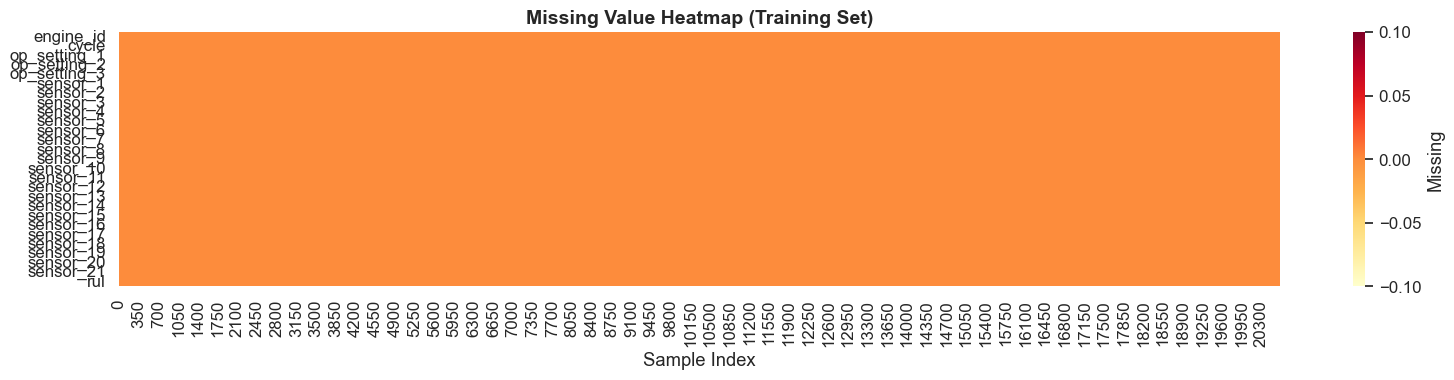


Total missing values: 0
✓ No missing values — C-MAPSS is a clean simulation dataset.


In [6]:
# Data types
dtype_summary = pd.DataFrame({
    "dtype": train_df.dtypes,
    "non_null": train_df.count(),
    "null_count": train_df.isnull().sum(),
    "null_pct": (train_df.isnull().sum() / len(train_df) * 100).round(2),
    "unique": train_df.nunique(),
}).sort_values("null_pct", ascending=False)

display(dtype_summary)

# Missing values heatmap
fig, ax = plt.subplots(figsize=(16, 4))
sns.heatmap(
    train_df.isnull().T,
    cbar_kws={"label": "Missing"},
    yticklabels=True,
    cmap="YlOrRd",
    ax=ax,
)
ax.set_title("Missing Value Heatmap (Training Set)", fontsize=14, fontweight="bold")
ax.set_xlabel("Sample Index")
plt.tight_layout()
plt.show()

total_missing = train_df.isnull().sum().sum()
print(f"\nTotal missing values: {total_missing:,}")
if total_missing == 0:
    print("✓ No missing values — C-MAPSS is a clean simulation dataset.")

## 5. Descriptive Statistics

Sensor readings span different physical quantities (temperature, pressure, speed, ratios). Some sensors show near-zero variance in FD001 and carry no discriminative signal.

In [7]:
# Full descriptive statistics for sensor channels
sensor_stats = train_df[SENSOR_COLUMNS].describe().T
sensor_stats["range"] = sensor_stats["max"] - sensor_stats["min"]
sensor_stats["cv"] = sensor_stats["std"] / sensor_stats["mean"].abs()  # Coefficient of variation
sensor_stats["skew"] = train_df[SENSOR_COLUMNS].skew()
sensor_stats["kurtosis"] = train_df[SENSOR_COLUMNS].kurtosis()

display(sensor_stats.round(4))

# Highlight low-variance sensors
print(f"\n{'─' * 50}")
print(f"Low-variance sensors (near-constant in FD001):")
for s in LOW_VARIANCE_SENSORS:
    rng = sensor_stats.loc[s, "range"]
    std = sensor_stats.loc[s, "std"]
    print(f"  {s:12s}  range={rng:.6f}  std={std:.6f}")
print(f"\nThese {len(LOW_VARIANCE_SENSORS)} sensors are typically dropped before modeling.")

,count,mean,std,min,25%,50%,75%,max,range,cv,skew,kurtosis
sensor_1,20631.0000,518.6700,0.0000,518.6700,518.6700,518.6700,518.6700,518.6700,0.0000,0.0000,0.0000,0.0000
sensor_2,20631.0000,642.6809,0.5001,641.2100,642.3250,642.6400,643.0000,644.5300,3.3200,0.0008,0.3165,-0.1120
sensor_3,20631.0000,1590.5231,6.1311,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100,45.8700,0.0039,0.3089,0.0078
sensor_4,20631.0000,1408.9338,9.0006,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900,59.2400,0.0064,0.4432,-0.1637
sensor_5,20631.0000,14.6200,0.0000,14.6200,14.6200,14.6200,14.6200,14.6200,0.0000,0.0000,0.0000,0.0000
sensor_6,20631.0000,21.6098,0.0014,21.6000,21.6100,21.6100,21.6100,21.6100,0.0100,0.0001,-6.9168,45.8467
sensor_7,20631.0000,553.3677,0.8851,549.8500,552.8100,553.4400,554.0100,556.0600,6.2100,0.0016,-0.3943,-0.1579
sensor_8,20631.0000,2388.0967,0.0710,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600,0.6600,0.0000,0.4794,0.3331
sensor_9,20631.0000,9065.2429,22.0829,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900,222.8600,0.0024,2.5554,9.3787
sensor_10,20631.0000,1.3000,0.0000,1.3000,1.3000,1.3000,1.3000,1.3000,0.0000,0.0000,0.0000,0.0000



──────────────────────────────────────────────────
Low-variance sensors (near-constant in FD001):
  sensor_1      range=0.000000  std=0.000000
  sensor_5      range=0.000000  std=0.000000
  sensor_6      range=0.010000  std=0.001389
  sensor_10     range=0.000000  std=0.000000
  sensor_16     range=0.000000  std=0.000000
  sensor_18     range=0.000000  std=0.000000
  sensor_19     range=0.000000  std=0.000000

These 7 sensors are typically dropped before modeling.


## 6. Sensor Degradation Traces

Visualize how individual sensor readings evolve across engine lifecycles. Sensors that show a clear trend as RUL approaches 0 are the most predictive.

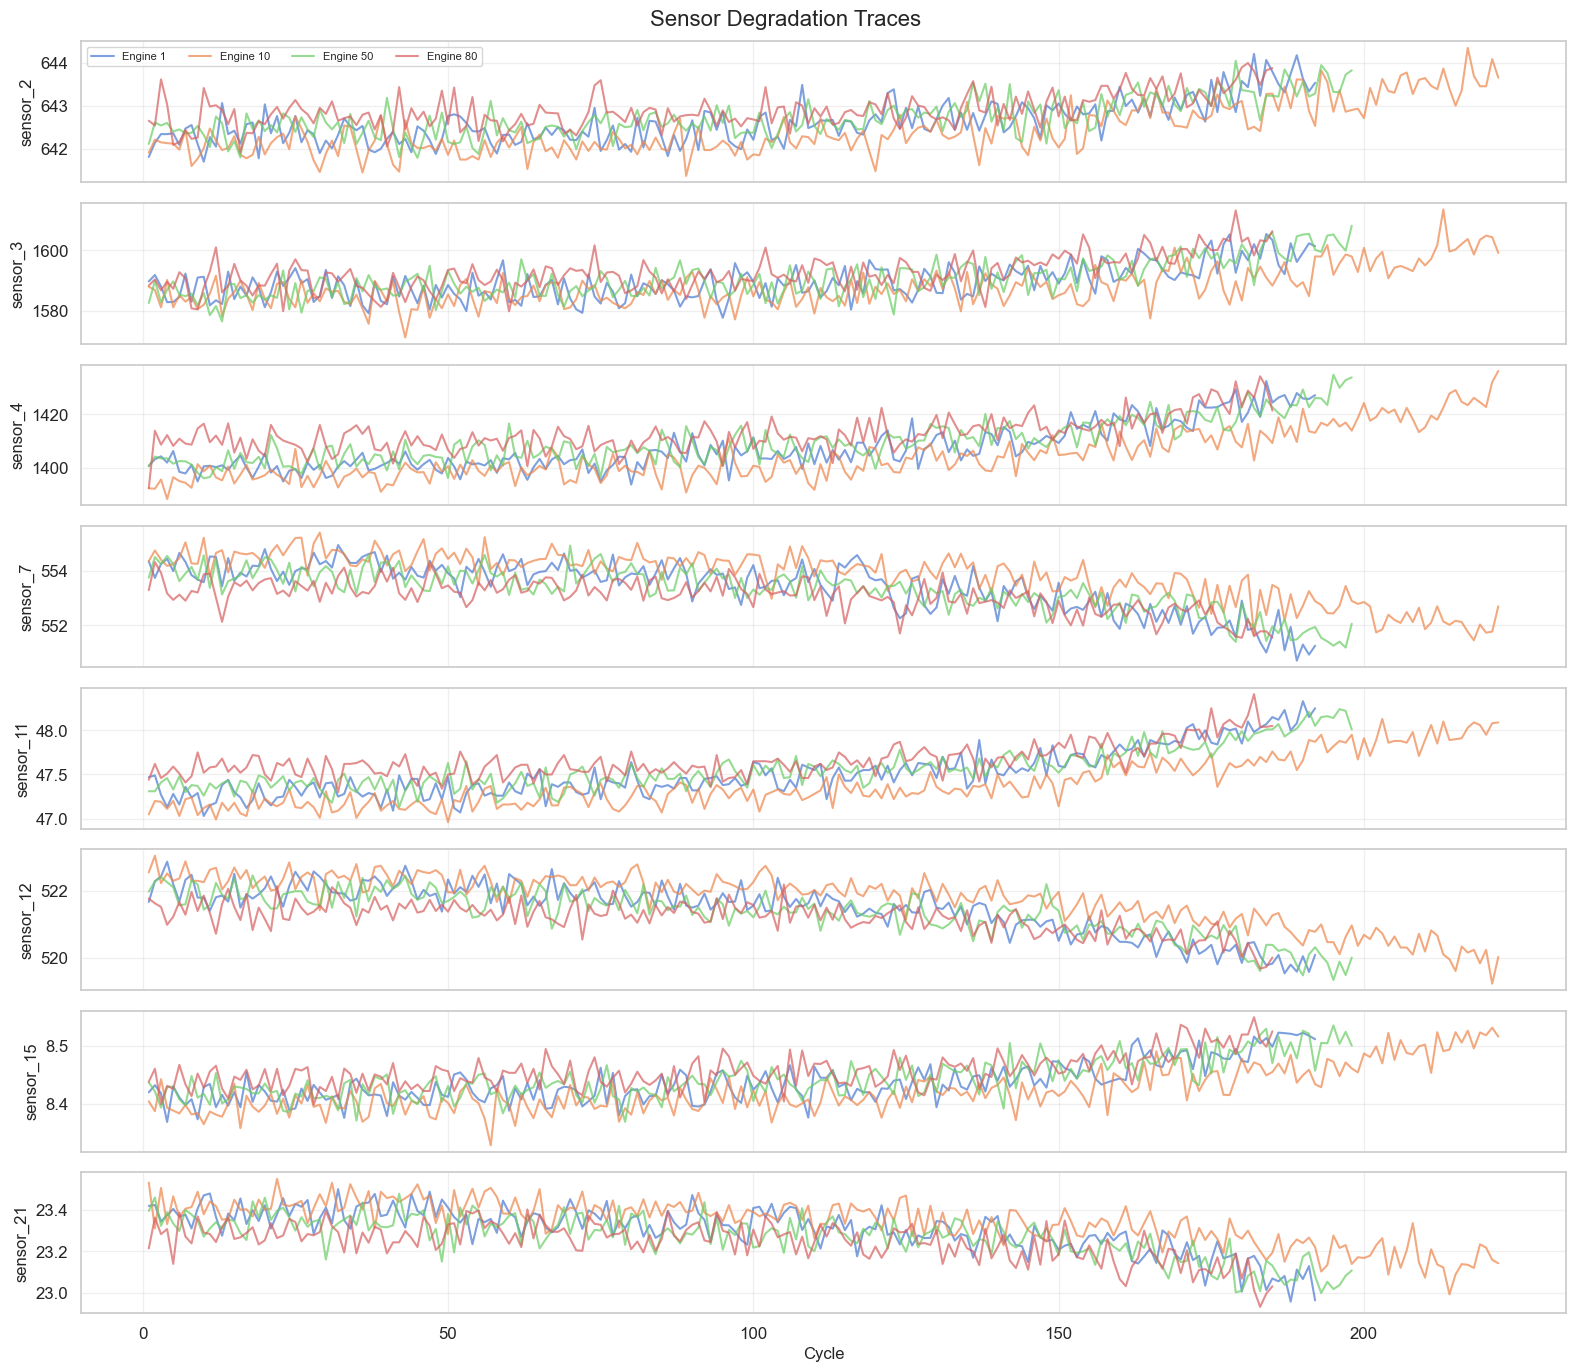

In [8]:
# Select a few representative engines and informative sensors
sample_engines = [1, 10, 50, 80]
informative_sensors = ["sensor_2", "sensor_3", "sensor_4", "sensor_7",
                       "sensor_11", "sensor_12", "sensor_15", "sensor_21"]

fig = plot_sensor_traces(train_df, engine_ids=sample_engines, sensors=informative_sensors,
                         figsize=(16, 14))
plt.show()

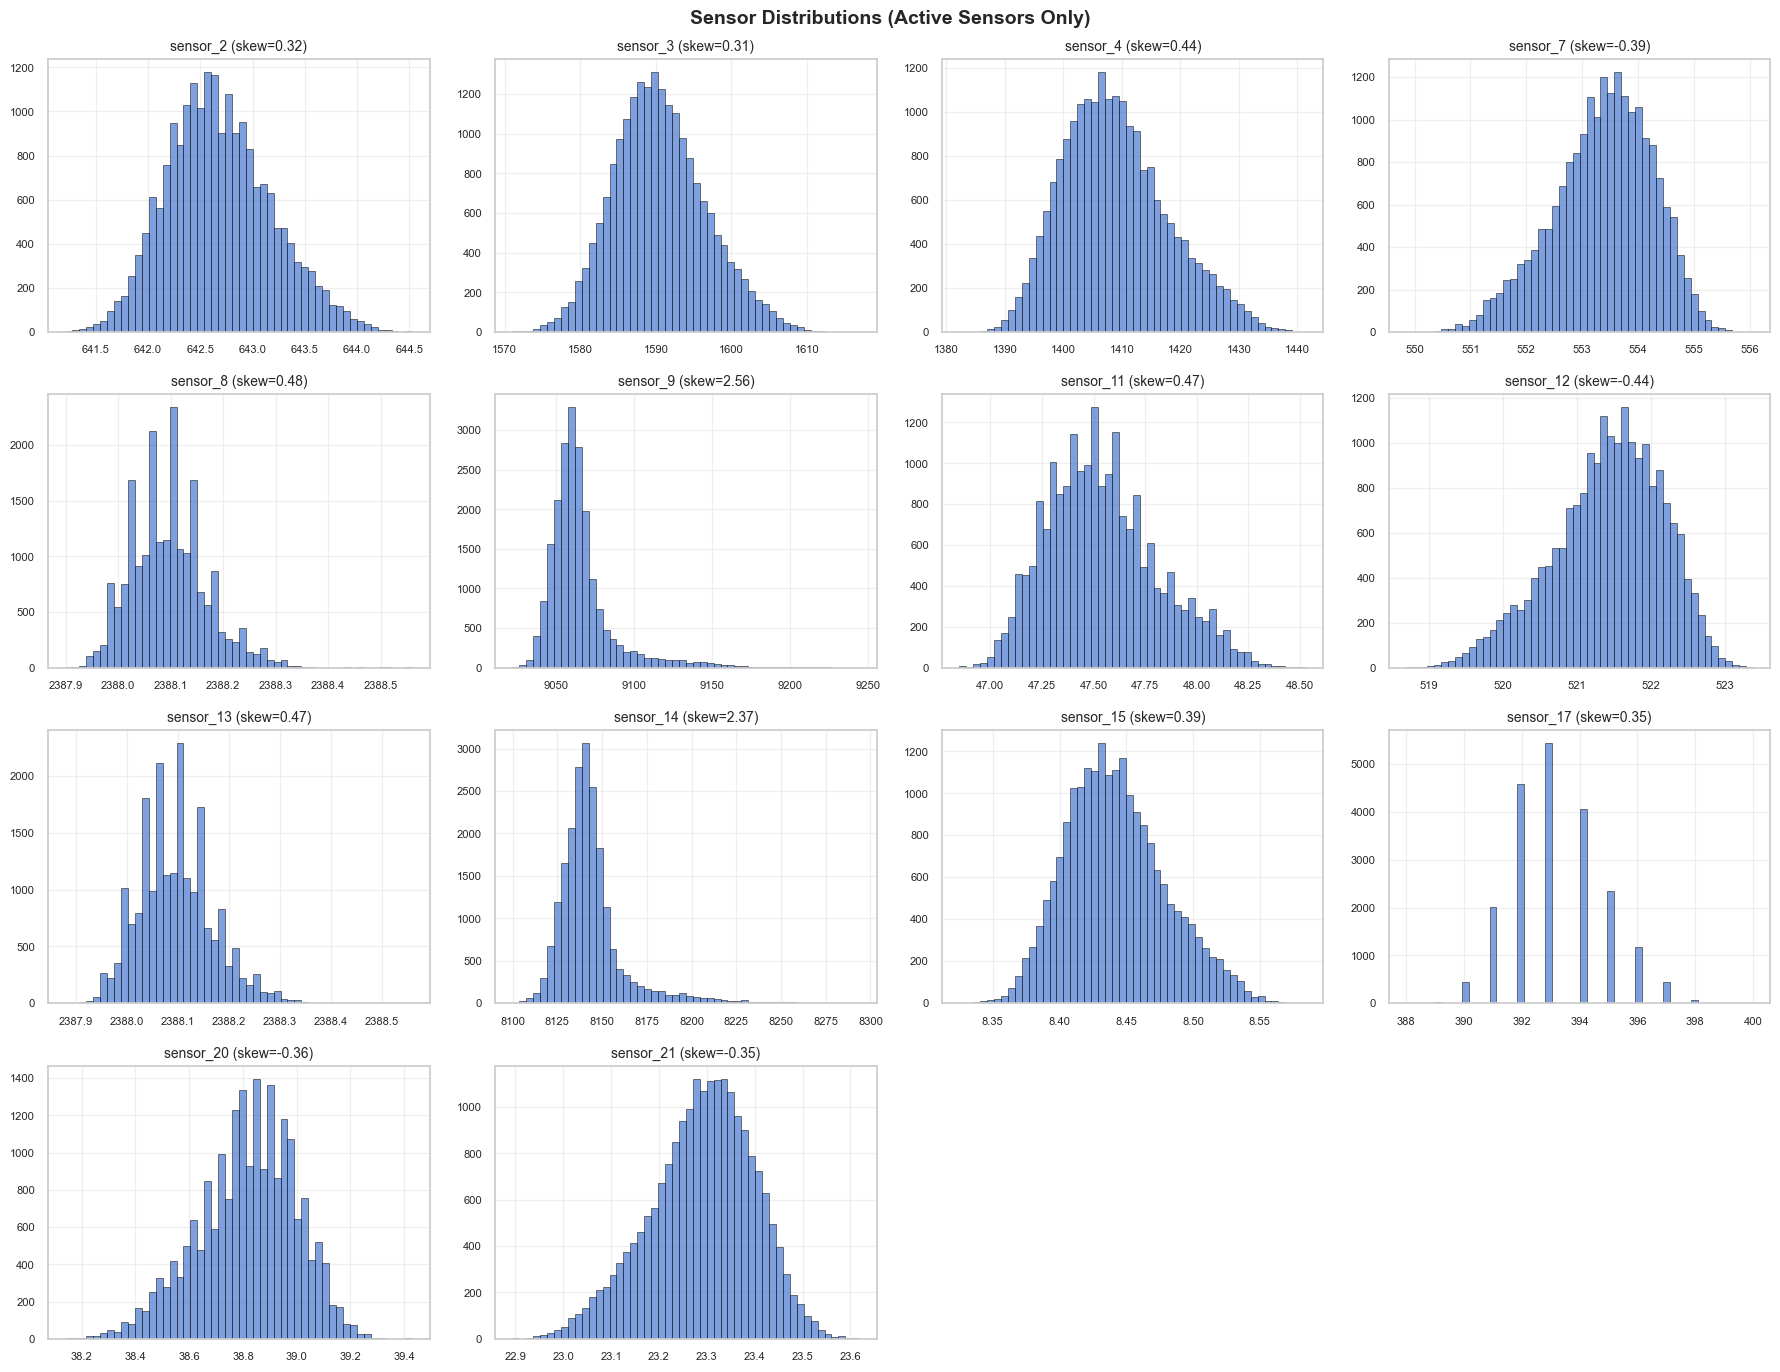

In [9]:
# Sensor distributions — histograms for all 21 sensors
active_sensors = [s for s in SENSOR_COLUMNS if s not in LOW_VARIANCE_SENSORS]

fig, axes = plt.subplots(4, 4, figsize=(18, 14))
axes_flat = axes.flatten()

for idx, sensor in enumerate(active_sensors[:16]):
    ax = axes_flat[idx]
    ax.hist(train_df[sensor], bins=50, alpha=0.7, edgecolor="black", linewidth=0.5)
    skew_val = train_df[sensor].skew()
    ax.set_title(f"{sensor} (skew={skew_val:.2f})", fontsize=10)
    ax.tick_params(labelsize=8)

# Hide unused subplots
for idx in range(len(active_sensors[:16]), len(axes_flat)):
    axes_flat[idx].set_visible(False)

fig.suptitle("Sensor Distributions (Active Sensors Only)", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

## 7. RUL Distribution & Piecewise-Linear Capping

The raw RUL is a linear countdown from max lifecycle to 0. Piecewise-linear capping at `max_rul=125` prevents the model from trying to predict exact RUL at engine start (where degradation hasn't begun and the signal is noisy).

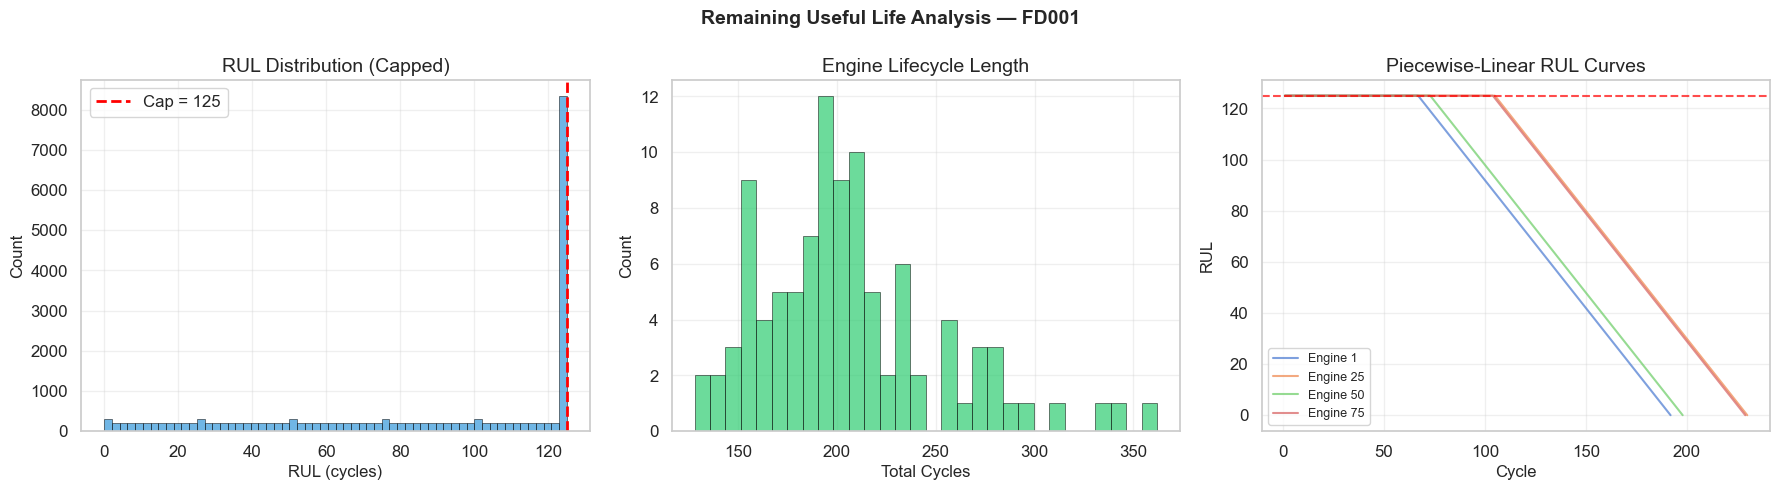

RUL capped at: 125 cycles
Fraction of samples at cap: 39.4%
RUL range: [0, 125]


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. RUL distribution (histogram)
axes[0].hist(train_df["rul"], bins=60, alpha=0.7, edgecolor="black", linewidth=0.5,
             color="#3498db")
axes[0].axvline(MAX_RUL, color="red", linestyle="--", linewidth=2, label=f"Cap = {MAX_RUL}")
axes[0].set_xlabel("RUL (cycles)")
axes[0].set_ylabel("Count")
axes[0].set_title("RUL Distribution (Capped)")
axes[0].legend()

# 2. Engine lifecycle length distribution
axes[1].hist(engine_lengths, bins=30, alpha=0.7, edgecolor="black", linewidth=0.5,
             color="#2ecc71")
axes[1].set_xlabel("Total Cycles")
axes[1].set_ylabel("Count")
axes[1].set_title("Engine Lifecycle Length")

# 3. RUL vs Cycle for a few engines (to show piecewise-linear shape)
for eid in [1, 25, 50, 75]:
    eng = train_df[train_df["engine_id"] == eid].sort_values("cycle")
    axes[2].plot(eng["cycle"], eng["rul"], label=f"Engine {eid}", alpha=0.7)
axes[2].axhline(MAX_RUL, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
axes[2].set_xlabel("Cycle")
axes[2].set_ylabel("RUL")
axes[2].set_title("Piecewise-Linear RUL Curves")
axes[2].legend(fontsize=9)

fig.suptitle(f"Remaining Useful Life Analysis — {SUBSET}", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

# Statistics
print(f"RUL capped at: {MAX_RUL} cycles")
print(f"Fraction of samples at cap: {(train_df['rul'] == MAX_RUL).mean():.1%}")
print(f"RUL range: [{train_df['rul'].min()}, {train_df['rul'].max()}]")

## 8. Operational Settings Analysis

FD001 has a single operating condition (sea level), so operational settings should be nearly constant. In FD002/FD004 (6 conditions), these become crucial for normalization.

,count,mean,std,min,25%,50%,75%,max
op_setting_1,20631.0000,-0.0000,0.0022,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0000,0.0000,0.0003,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0000,100.0000,0.0000,100.0000,100.0000,100.0000,100.0000,100.0000


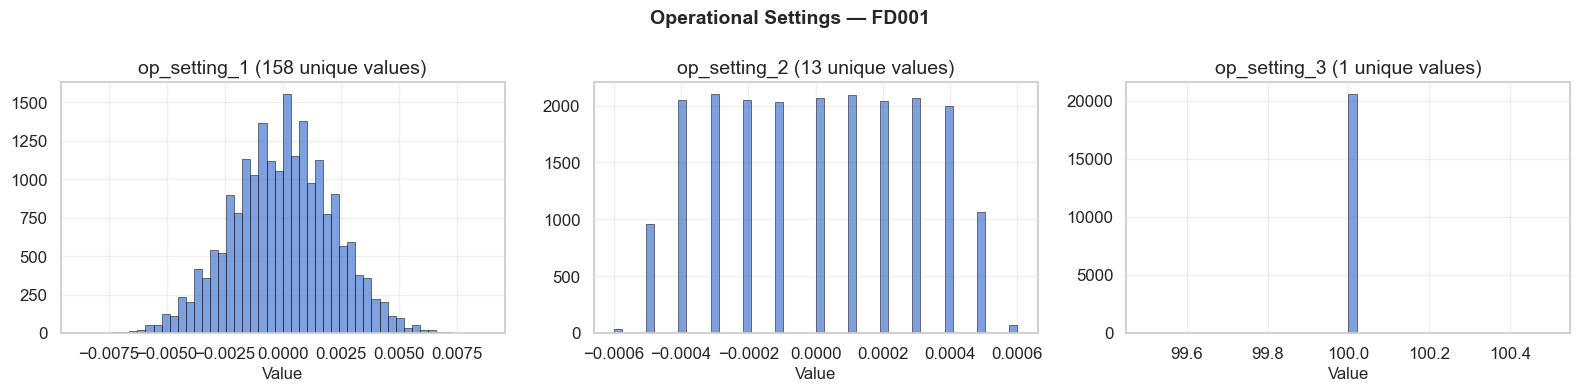

In [11]:
# Operational settings summary
op_stats = train_df[OPERATIONAL_SETTINGS].describe().T
display(op_stats)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for idx, col in enumerate(OPERATIONAL_SETTINGS):
    axes[idx].hist(train_df[col], bins=50, alpha=0.7, edgecolor="black", linewidth=0.5)
    n_unique = train_df[col].nunique()
    axes[idx].set_title(f"{col} ({n_unique} unique values)")
    axes[idx].set_xlabel("Value")

fig.suptitle(f"Operational Settings — {SUBSET}", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

## 9. Correlation Matrix & Bivariate Analysis

Identify which sensors are most correlated with RUL (potential top predictors) and which sensors are highly inter-correlated (redundancy).

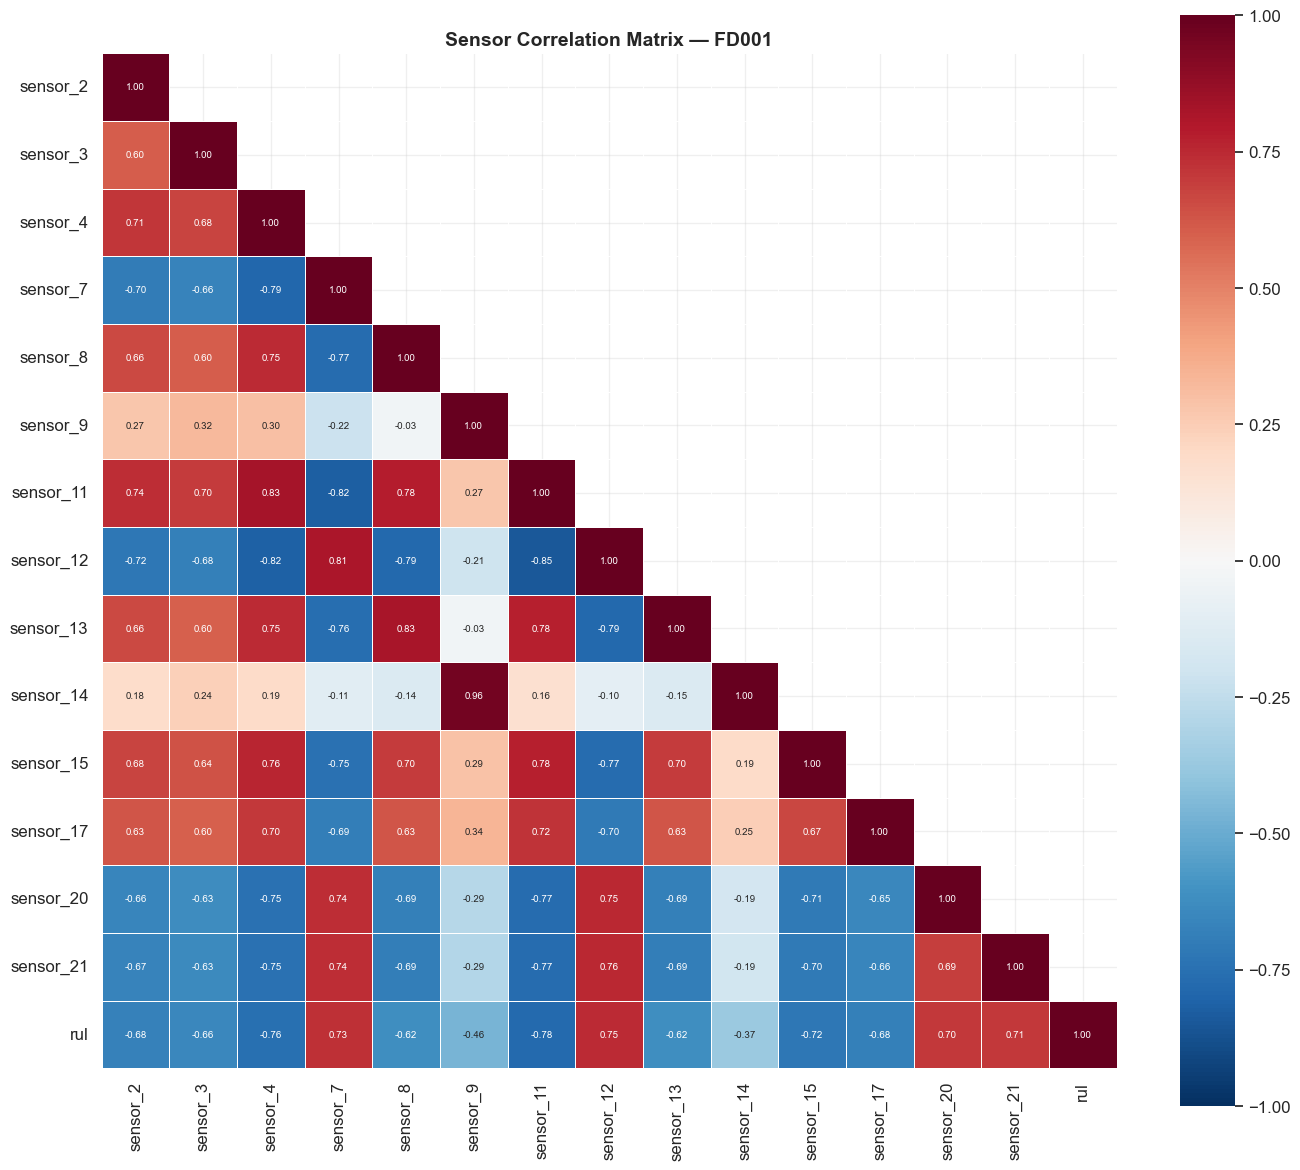

Sensor correlations with RUL (abs):
────────────────────────────────────────
  sensor_11     −0.775  ███████████████████████
  sensor_4      −0.757  ██████████████████████
  sensor_12     +0.749  ██████████████████████
  sensor_7      +0.733  █████████████████████
  sensor_15     −0.721  █████████████████████
  sensor_21     +0.707  █████████████████████
  sensor_20     +0.705  █████████████████████
  sensor_17     −0.681  ████████████████████
  sensor_2      −0.678  ████████████████████
  sensor_3      −0.655  ███████████████████
  sensor_8      −0.625  ██████████████████
  sensor_13     −0.624  ██████████████████
  sensor_9      −0.462  █████████████
  sensor_14     −0.370  ███████████


In [12]:
# Correlation matrix for active sensors + RUL
corr_cols = active_sensors + ["rul"]
corr_matrix = train_df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    ax=ax,
    annot_kws={"size": 7},
)
ax.set_title(f"Sensor Correlation Matrix — {SUBSET}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Top correlations with RUL
rul_corr = corr_matrix["rul"].drop("rul").abs().sort_values(ascending=False)
print("Sensor correlations with RUL (abs):")
print("─" * 40)
for sensor, corr in rul_corr.items():
    direction = "+" if corr_matrix.loc[sensor, "rul"] > 0 else "−"
    bar = "█" * int(corr * 30)
    print(f"  {sensor:12s}  {direction}{corr:.3f}  {bar}")

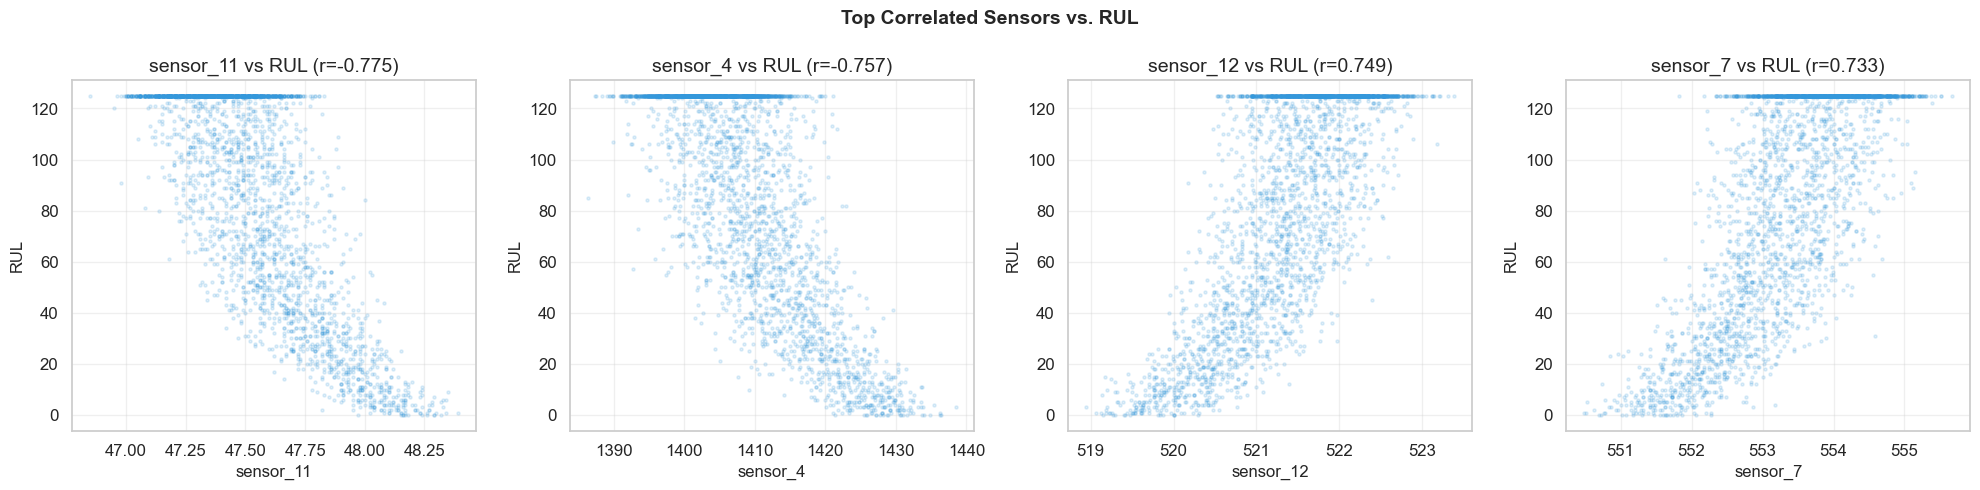

In [13]:
# Scatter plots: top 4 sensors vs RUL
top_sensors = rul_corr.head(4).index.tolist()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx, sensor in enumerate(top_sensors):
    ax = axes[idx]
    # Subsample for speed
    sample_idx = np.random.choice(len(train_df), size=min(3000, len(train_df)), replace=False)
    sample = train_df.iloc[sample_idx]
    ax.scatter(sample[sensor], sample["rul"], alpha=0.15, s=5, c="#3498db")
    ax.set_xlabel(sensor)
    ax.set_ylabel("RUL")
    r = corr_matrix.loc[sensor, "rul"]
    ax.set_title(f"{sensor} vs RUL (r={r:.3f})")

fig.suptitle("Top Correlated Sensors vs. RUL", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

## 10. Outlier Detection

Use IQR and z-score methods to identify sensor outliers. In C-MAPSS, "outliers" near failure are actually the signal we want to predict — extreme sensor values at low RUL are expected.

,iqr_outliers,iqr_outlier_pct,zscore_outliers,zscore_outlier_pct
sensor,,,,
sensor_9,1686,8.1700,521,2.5300
sensor_14,1543,7.4800,496,2.4000
sensor_8,320,1.5500,107,0.5200
sensor_11,167,0.8100,23,0.1100
sensor_3,165,0.8000,47,0.2300
sensor_13,161,0.7800,83,0.4000
sensor_12,146,0.7100,34,0.1600
sensor_21,136,0.6600,34,0.1600
sensor_2,128,0.6200,31,0.1500


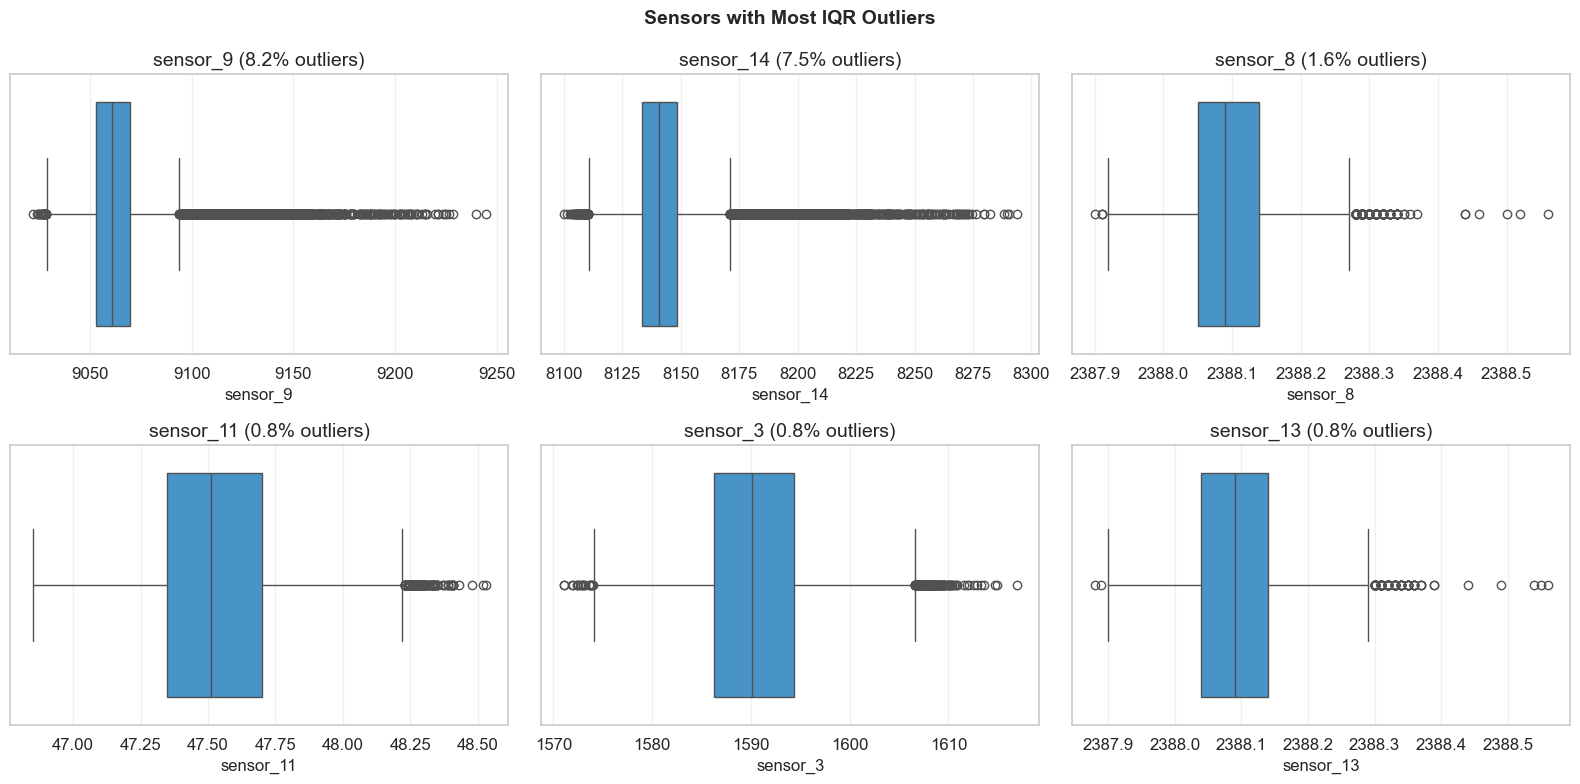


⚠ Note: In prognostics data, 'outliers' at end-of-life are the degradation
  signal. Do NOT remove them — they carry the most predictive information.


In [14]:
# IQR-based outlier detection for active sensors
outlier_summary = []
for sensor in active_sensors:
    Q1 = train_df[sensor].quantile(0.25)
    Q3 = train_df[sensor].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_outliers = ((train_df[sensor] < lower) | (train_df[sensor] > upper)).sum()
    z_outliers = (np.abs(stats.zscore(train_df[sensor])) > 3).sum()
    outlier_summary.append({
        "sensor": sensor,
        "iqr_outliers": n_outliers,
        "iqr_outlier_pct": n_outliers / len(train_df) * 100,
        "zscore_outliers": z_outliers,
        "zscore_outlier_pct": z_outliers / len(train_df) * 100,
    })

outlier_df = pd.DataFrame(outlier_summary).set_index("sensor")
display(outlier_df.round(2).sort_values("iqr_outlier_pct", ascending=False))

# Box plots for top outlier sensors
top_outlier_sensors = outlier_df.nlargest(6, "iqr_outlier_pct").index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for idx, sensor in enumerate(top_outlier_sensors):
    ax = axes.flatten()[idx]
    sns.boxplot(data=train_df, x=sensor, ax=ax, color="#3498db")
    ax.set_title(f"{sensor} ({outlier_df.loc[sensor, 'iqr_outlier_pct']:.1f}% outliers)")

fig.suptitle("Sensors with Most IQR Outliers", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

print(f"\n⚠ Note: In prognostics data, 'outliers' at end-of-life are the degradation")
print(f"  signal. Do NOT remove them — they carry the most predictive information.")

## 11. Feature Engineering Pipeline

Build the full engineered feature set using TurboFault's `build_feature_set()` function: rolling statistics, lag features, rate-of-change deltas, EWMA smoothing, and cycle normalization.

In [15]:
# Drop low-variance sensors first
train_clean = drop_low_variance_sensors(train_df)

# Use active sensors for feature engineering
active = [s for s in SENSOR_COLUMNS if s not in LOW_VARIANCE_SENSORS]

# Build full feature set
train_feat = build_feature_set(
    train_clean,
    sensors=active,
    rolling_windows=(5, 10, 20),
    rolling_stats=("mean", "std"),
    lags=(1, 3, 5),
    delta_periods=(1, 5),
    ewma_spans=(10, 20),
    include_cycle=True,
)

feature_cols = get_feature_columns(train_feat, include_operational=True, include_raw_sensors=True)

print(f"Original features:     {len(SENSOR_COLUMNS) + len(OPERATIONAL_SETTINGS)}")
print(f"Engineered features:   {len(feature_cols)}")
print(f"Training samples:      {len(train_feat):,}")
print(f"\nFeature breakdown:")
print(f"  Raw sensors:    {len(active)}")
print(f"  Rolling stats:  {sum(1 for c in feature_cols if '_roll' in c)}")
print(f"  Lag features:   {sum(1 for c in feature_cols if '_lag' in c)}")
print(f"  Delta features: {sum(1 for c in feature_cols if '_delta' in c)}")
print(f"  EWMA features:  {sum(1 for c in feature_cols if '_ewma' in c)}")
print(f"  Cycle features: {sum(1 for c in feature_cols if 'cycle' in c)}")
print(f"  Op settings:    {sum(1 for c in feature_cols if 'op_setting' in c)}")

Original features:     24
Engineered features:   201
Training samples:      20,631

Feature breakdown:
  Raw sensors:    14
  Rolling stats:  84
  Lag features:   42
  Delta features: 28
  EWMA features:  28
  Cycle features: 2
  Op settings:    3


## 12. Baseline Models

Train XGBoost, Random Forest, and Ridge Regression on the engineered feature set. These tabular baselines set the performance bar for deep learning models (LSTM, Transformer, 1D-CNN).

In [16]:
# Prepare data with temporal split and normalization
# Re-engineer features on both train and test sets using the dataset object
dataset.train_df = drop_low_variance_sensors(dataset.train_df)
dataset.test_df = drop_low_variance_sensors(dataset.test_df)

# Full feature engineering on train
train_eng = build_feature_set(dataset.train_df, sensors=active)
feat_cols = get_feature_columns(train_eng)

# Normalize
train_norm, _, scaler = normalize_sensors(train_eng, columns=feat_cols)

# Temporal train/val split
train_split, val_split = temporal_train_val_split(train_norm, val_fraction=0.2)

# Test: feature engineer and get last cycle
test_eng = build_feature_set(dataset.test_df, sensors=active)
_, test_norm, _ = normalize_sensors(train_eng, test_eng, columns=feat_cols)
test_last = get_last_cycle_per_engine(test_norm)

# Ensure consistent feature columns
feat_cols = [c for c in feat_cols if c in train_split.columns and c in test_last.columns]

X_train = train_split[feat_cols].values
y_train = train_split["rul"].values
X_val = val_split[feat_cols].values
y_val = val_split["rul"].values
X_test = test_last[feat_cols].values
y_test = test_last["rul"].values

# Fill NaN from rolling/lag/delta features at series boundaries
# (XGBoost/RF handle NaN natively, but Ridge/linear models require finite values)
nan_before = np.isnan(X_train).sum()
X_train = np.nan_to_num(X_train, nan=0.0)
X_val = np.nan_to_num(X_val, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

print(f"X_train: {X_train.shape}  |  X_val: {X_val.shape}  |  X_test: {X_test.shape}")
print(f"Features: {len(feat_cols)}")
print(f"NaN values filled: {nan_before:,}")

X_train: (16138, 201)  |  X_val: (4493, 201)  |  X_test: (100, 201)
Features: 201
NaN values filled: 3,360


In [17]:
# ── XGBoost ──────────────────────────────────────────────────────────
xgb_model = XGBoostRUL(n_estimators=500, max_depth=6, learning_rate=0.05)
xgb_model.fit(X_train, y_train, X_val, y_val)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Results:")
xgb_results = evaluate_rul(y_test, xgb_pred, prefix="xgb_")

[0]	validation_0-rmse:39.87167
[50]	validation_0-rmse:13.69062
[100]	validation_0-rmse:13.60320
[117]	validation_0-rmse:13.62092
XGBoost Results:
————————————————————————————————————————
RMSE:        69.48
MAE:         59.98
R²:          -2.0065
NASA Score:  79192.90
————————————————————————————————————————


In [18]:
# ── Random Forest ────────────────────────────────────────────────────
rf_model = RandomForestRUL(n_estimators=300, max_depth=12)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Results:")
rf_results = evaluate_rul(y_test, rf_pred, prefix="rf_")

Random Forest Results:
————————————————————————————————————————
RMSE:        84.55
MAE:         74.45
R²:          -3.4516
NASA Score:  340402.22
————————————————————————————————————————


In [19]:
# ── Ridge Regression ─────────────────────────────────────────────────
ridge_model = RidgeRUL(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

print("Ridge Regression Results:")
ridge_results = evaluate_rul(y_test, ridge_pred, prefix="ridge_")

Ridge Regression Results:
————————————————————————————————————————
RMSE:        86.79
MAE:         77.87
R²:          -3.6906
NASA Score:  394857.95
————————————————————————————————————————


In [20]:
# ── Model Comparison ─────────────────────────────────────────────────
all_results = {
    "XGBoost": {k.replace("xgb_", ""): v for k, v in xgb_results.items()},
    "Random Forest": {k.replace("rf_", ""): v for k, v in rf_results.items()},
    "Ridge": {k.replace("ridge_", ""): v for k, v in ridge_results.items()},
}

comparison = print_comparison_table(all_results)
print(comparison)

Model                        RMSE          MAE           R2   NASA_SCORE
────────────────────────────────────────────────────────────────────────
XGBoost                     69.48        59.98      -2.0065     79192.90
Random Forest               84.55        74.45      -3.4516    340402.22
Ridge                       86.79        77.87      -3.6906    394857.95
Model                        RMSE          MAE           R2   NASA_SCORE
────────────────────────────────────────────────────────────────────────
XGBoost                     69.48        59.98      -2.0065     79192.90
Random Forest               84.55        74.45      -3.4516    340402.22
Ridge                       86.79        77.87      -3.6906    394857.95


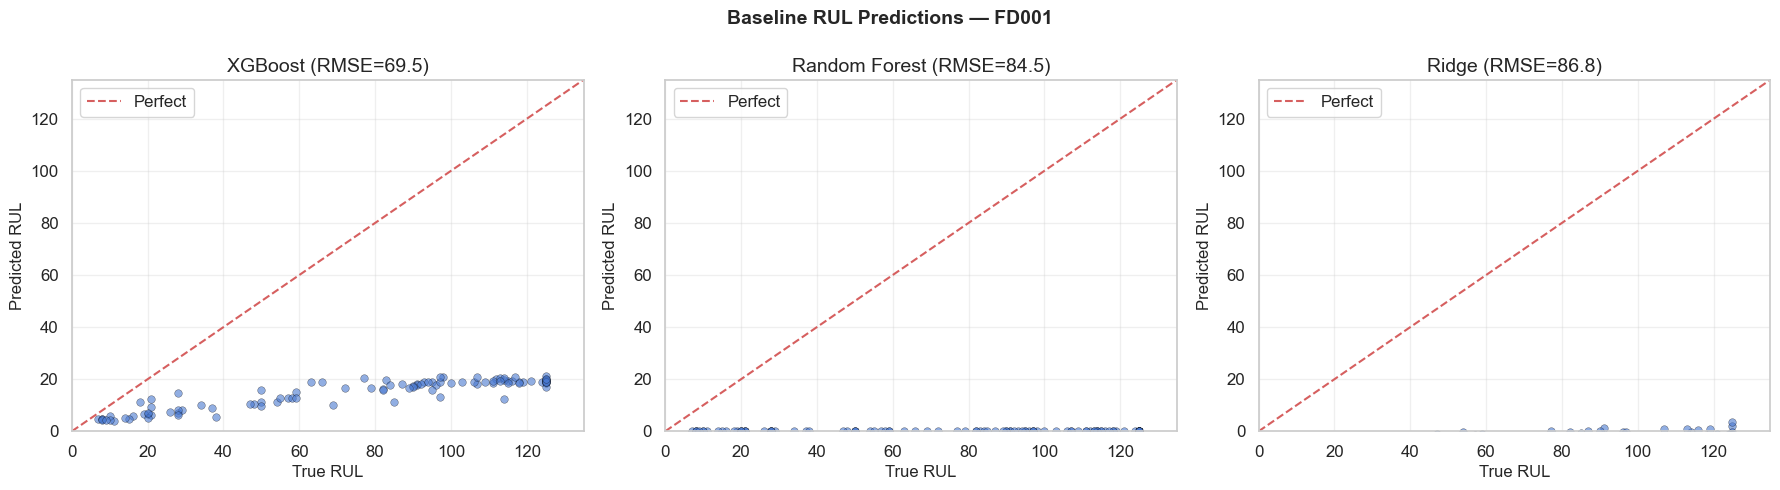

In [21]:
# Prediction scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = [("XGBoost", xgb_pred), ("Random Forest", rf_pred), ("Ridge", ridge_pred)]

for idx, (name, pred) in enumerate(models):
    ax = axes[idx]
    ax.scatter(y_test, pred, alpha=0.6, s=30, edgecolors="black", linewidth=0.3)
    lims = [0, max(y_test.max(), pred.max()) + 10]
    ax.plot(lims, lims, "r--", linewidth=1.5, label="Perfect")
    ax.set_xlabel("True RUL")
    ax.set_ylabel("Predicted RUL")
    rmse = all_results[name]["rmse"]
    ax.set_title(f"{name} (RMSE={rmse:.1f})")
    ax.legend()
    ax.set_xlim(lims)
    ax.set_ylim(lims)

fig.suptitle(f"Baseline RUL Predictions — {SUBSET}", fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

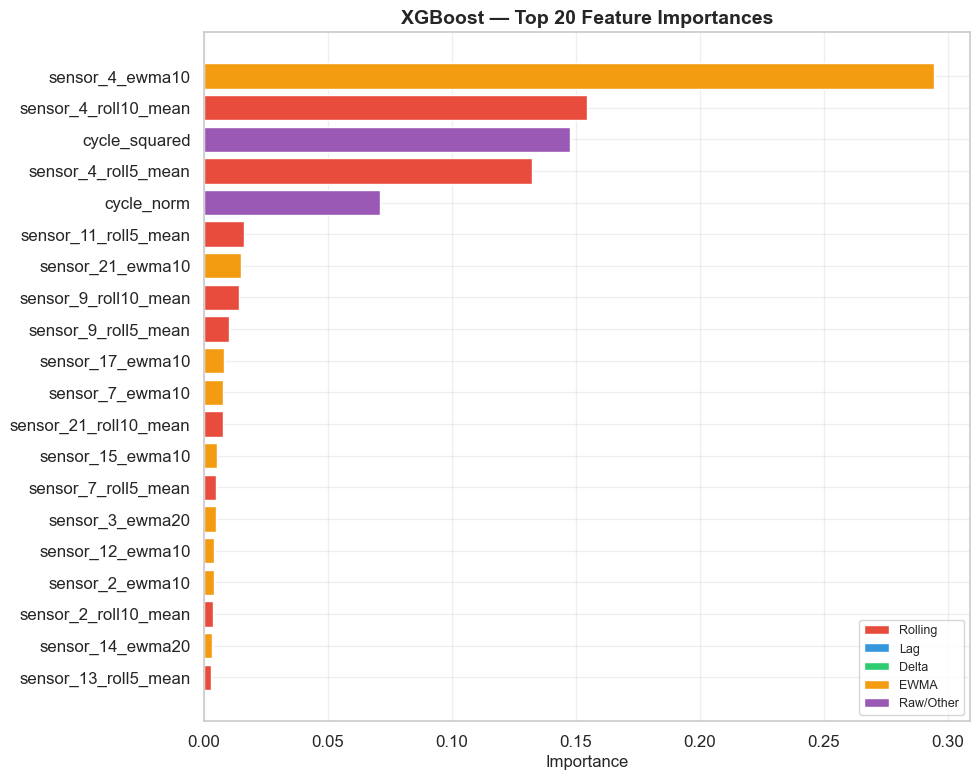

In [22]:
# XGBoost feature importance — top 20
importance = xgb_model.get_feature_importance(feature_names=feat_cols, top_n=20)

fig, ax = plt.subplots(figsize=(10, 8))
names = [p[0] for p in reversed(importance)]
scores = [p[1] for p in reversed(importance)]
colors = ["#e74c3c" if "roll" in n else "#3498db" if "lag" in n
          else "#2ecc71" if "delta" in n else "#f39c12" if "ewma" in n
          else "#9b59b6" for n in names]
ax.barh(names, scores, color=colors)
ax.set_xlabel("Importance")
ax.set_title("XGBoost — Top 20 Feature Importances", fontsize=14, fontweight="bold")

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#e74c3c", label="Rolling"),
    Patch(facecolor="#3498db", label="Lag"),
    Patch(facecolor="#2ecc71", label="Delta"),
    Patch(facecolor="#f39c12", label="EWMA"),
    Patch(facecolor="#9b59b6", label="Raw/Other"),
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

## 13. Key Findings & Summary

In [23]:
# Compile per-column summary table
summary_data = []
all_cols = active_sensors + OPERATIONAL_SETTINGS
for col in all_cols:
    col_data = train_df[col]
    rul_r = train_df[["rul", col]].corr().iloc[0, 1] if "rul" in train_df.columns else np.nan
    iqr_out = outlier_df.loc[col, "iqr_outliers"] if col in outlier_df.index else 0
    summary_data.append({
        "column": col,
        "dtype": str(col_data.dtype),
        "missing": col_data.isnull().sum(),
        "unique": col_data.nunique(),
        "mean": col_data.mean(),
        "std": col_data.std(),
        "rul_corr": rul_r,
        "iqr_outliers": iqr_out,
        "low_variance": col in LOW_VARIANCE_SENSORS,
    })

summary_df = pd.DataFrame(summary_data).set_index("column")
summary_df = summary_df.sort_values("rul_corr", key=abs, ascending=False)
display(summary_df.round(4))

print(f"\n{'═' * 60}")
print(f"KEY FINDINGS — C-MAPSS {SUBSET}")
print(f"{'═' * 60}")
print(f"  • {len(train_df):,} training samples across {dataset.num_train_engines} engines")
print(f"  • {len(active_sensors)} informative sensors ({len(LOW_VARIANCE_SENSORS)} low-variance dropped)")
print(f"  • No missing values (simulation data)")
print(f"  • Engine lifecycles range from {engine_lengths.min()} to {engine_lengths.max()} cycles")
print(f"  • RUL capped at {MAX_RUL} cycles (piecewise-linear)")
print(f"  • {len(feat_cols)} total engineered features")
print(f"")
print(f"BASELINE PERFORMANCE (Test Set):")
for name, res in all_results.items():
    print(f"  {name:15s}  RMSE={res['rmse']:.2f}  MAE={res['mae']:.2f}  "
          f"R²={res['r2']:.4f}  NASA={res['nasa_score']:.0f}")
print(f"{'═' * 60}")

,dtype,missing,unique,mean,std,rul_corr,iqr_outliers,low_variance
column,,,,,,,,
sensor_11,float64,0,159,47.5412,0.2671,-0.7752,167,False
sensor_4,float64,0,4051,1408.9338,9.0006,-0.7572,120,False
sensor_12,float64,0,427,521.4135,0.7376,0.7489,146,False
sensor_7,float64,0,513,553.3677,0.8851,0.7330,110,False
sensor_15,float64,0,1918,8.4421,0.0375,-0.7209,120,False
sensor_21,float64,0,4745,23.2897,0.1083,0.7073,136,False
sensor_20,float64,0,120,38.8163,0.1807,0.7046,117,False
sensor_17,int64,0,13,393.2107,1.5488,-0.6808,81,False
sensor_2,float64,0,310,642.6809,0.5001,-0.6785,128,False



════════════════════════════════════════════════════════════
KEY FINDINGS — C-MAPSS FD001
════════════════════════════════════════════════════════════
  • 20,631 training samples across 100 engines
  • 14 informative sensors (7 low-variance dropped)
  • No missing values (simulation data)
  • Engine lifecycles range from 128 to 362 cycles
  • RUL capped at 125 cycles (piecewise-linear)
  • 201 total engineered features

BASELINE PERFORMANCE (Test Set):
  XGBoost          RMSE=69.48  MAE=59.98  R²=-2.0065  NASA=79193
  Random Forest    RMSE=84.55  MAE=74.45  R²=-3.4516  NASA=340402
  Ridge            RMSE=86.79  MAE=77.87  R²=-3.6906  NASA=394858
════════════════════════════════════════════════════════════


## 14. Feature Explainability

Understand _which sensors and engineered features_ drive the XGBoost RUL predictions using **permutation importance** and **sensor contribution analysis**.

Permutation importance shuffles each feature independently and measures the increase in prediction error — features that cause the largest error increase when shuffled are the most important.

In [24]:
from turbofault.explain.feature_explainer import (
    permutation_importance,
    sensor_contribution_analysis,
    generate_explanation_report,
)

# ── Permutation Importance ──────────────────────────────────────────
perm_imp = permutation_importance(
    xgb_model, X_test, y_test,
    feature_names=feat_cols,
    n_repeats=10,
    metric="rmse",
)

print("Top 20 Features by Permutation Importance (RMSE increase when shuffled):")
print("─" * 60)
display(perm_imp.head(20))

Top 20 Features by Permutation Importance (RMSE increase when shuffled):
────────────────────────────────────────────────────────────


,feature,importance_mean,importance_std
0,sensor_4_roll10_mean,0.4880,0.0979
1,sensor_9_roll10_mean,0.3708,0.0824
2,sensor_11_roll5_mean,0.2550,0.0538
3,sensor_4_roll5_mean,0.2289,0.0486
4,sensor_9_roll5_mean,0.1439,0.0492
5,sensor_17_ewma10,0.1011,0.0377
6,sensor_9_roll20_mean,0.0964,0.0509
7,sensor_14_ewma20,0.0896,0.0458
8,sensor_3_roll5_mean,0.0662,0.0226
9,sensor_17_ewma20,0.0630,0.0121


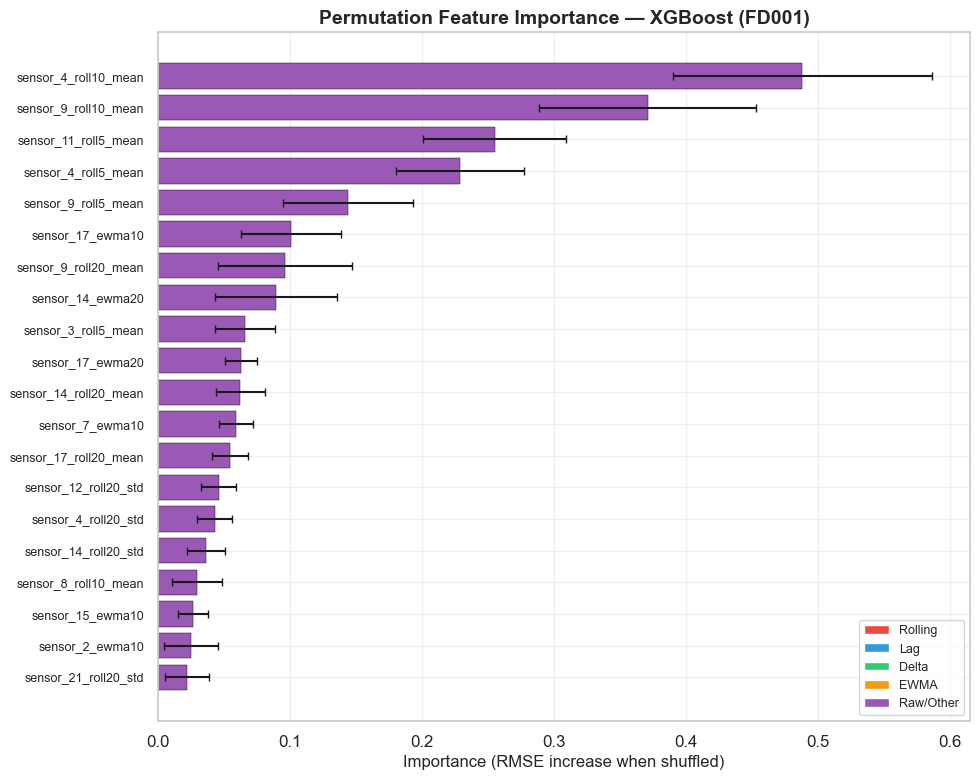

In [25]:
# ── Permutation Importance Bar Chart ─────────────────────────────────
top_n = 20
top_perm = perm_imp.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
colors = []
for name in reversed(top_perm["feature"].values):
    if "_roll_" in name:
        colors.append("#e74c3c")
    elif "_lag_" in name:
        colors.append("#3498db")
    elif "_delta_" in name:
        colors.append("#2ecc71")
    elif "_ewma_" in name:
        colors.append("#f39c12")
    else:
        colors.append("#9b59b6")

ax.barh(
    range(top_n),
    list(reversed(top_perm["importance_mean"].values)),
    xerr=list(reversed(top_perm["importance_std"].values)),
    color=colors,
    edgecolor="black",
    linewidth=0.3,
    capsize=3,
)
ax.set_yticks(range(top_n))
ax.set_yticklabels(list(reversed(top_perm["feature"].values)), fontsize=9)
ax.set_xlabel("Importance (RMSE increase when shuffled)")
ax.set_title(f"Permutation Feature Importance — XGBoost ({SUBSET})",
             fontsize=14, fontweight="bold")

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#e74c3c", label="Rolling"),
    Patch(facecolor="#3498db", label="Lag"),
    Patch(facecolor="#2ecc71", label="Delta"),
    Patch(facecolor="#f39c12", label="EWMA"),
    Patch(facecolor="#9b59b6", label="Raw/Other"),
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

### Sensor Contribution Analysis

Group feature importances by their **base sensor** to answer: "Which physical sensor channels contribute most to RUL prediction?" This aggregates importance across all derived features (rolling, lag, delta, EWMA) for each sensor.

In [26]:
# ── Sensor Contribution Analysis ────────────────────────────────────
analysis = sensor_contribution_analysis(perm_imp, top_n=20)

print("Sensor Ranking (by total importance across all derived features):")
print("─" * 60)
display(analysis["sensor_ranking"].round(4))

print("\nFeature Type Ranking:")
print("─" * 60)
display(analysis["feature_type_ranking"].round(4))

Sensor Ranking (by total importance across all derived features):
────────────────────────────────────────────────────────────


,total_importance,avg_importance,n_features
sensor,,,
sensor_4,0.7319,0.0523,14
sensor_9,0.6224,0.0445,14
sensor_17,0.2122,0.0152,14
sensor_14,0.2118,0.0151,14
sensor_11,0.2034,0.0145,14
sensor_3,0.0348,0.0025,14
sensor_7,0.0312,0.0022,14
sensor_12,0.0264,0.0019,14
sensor_15,0.0196,0.0014,14



Feature Type Ranking:
────────────────────────────────────────────────────────────


,total_importance,avg_importance,n_features
feature_type,,,
raw,1.9516,0.0100,196
cycle,0.0000,0.0000,2
operational,0.0000,0.0000,3


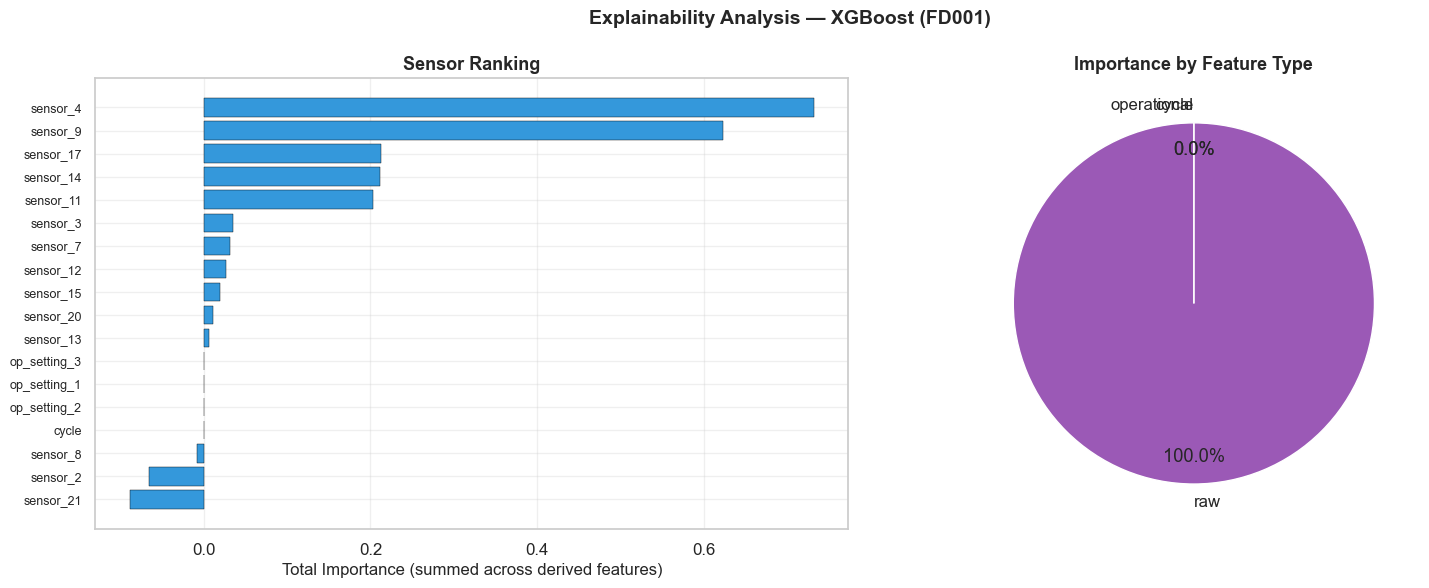

In [27]:
# ── Sensor Importance Visualization ─────────────────────────────────
sensor_rank = analysis["sensor_ranking"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Sensor ranking bar chart
sensors = sensor_rank.index.tolist()
totals = sensor_rank["total_importance"].values
ax1.barh(range(len(sensors)), totals[::-1], color="#3498db",
         edgecolor="black", linewidth=0.3)
ax1.set_yticks(range(len(sensors)))
ax1.set_yticklabels(sensors[::-1], fontsize=9)
ax1.set_xlabel("Total Importance (summed across derived features)")
ax1.set_title("Sensor Ranking", fontsize=13, fontweight="bold")

# Right: Feature type pie chart
type_rank = analysis["feature_type_ranking"]
type_colors = {
    "rolling": "#e74c3c", "lag": "#3498db", "delta": "#2ecc71",
    "ewma": "#f39c12", "raw": "#9b59b6", "operational": "#1abc9c",
    "cycle": "#95a5a6",
}
colors = [type_colors.get(t, "#bdc3c7") for t in type_rank.index]
ax2.pie(type_rank["total_importance"], labels=type_rank.index,
        colors=colors, autopct="%1.1f%%", startangle=90, pctdistance=0.85)
ax2.set_title("Importance by Feature Type", fontsize=13, fontweight="bold")

fig.suptitle(f"Explainability Analysis — XGBoost ({SUBSET})",
             fontsize=14, fontweight="bold")
fig.tight_layout()
plt.show()

In [28]:
# ── Full Explanation Report ──────────────────────────────────────────
report = generate_explanation_report("XGBoost", perm_imp, analysis, top_n=15)
print(report)

print(f"\nNEXT STEPS:")
print(f"  1. Train LSTM, GRU, Transformer, 1D-CNN on sequence data")
print(f"  2. Compare deep models against these baselines")
print(f"  3. Run Optuna hyperparameter search (turbofault tune)")
print(f"  4. Extract Transformer attention weights for temporal explainability")
print(f"  5. Extend to FD002–FD004 (multi-condition, multi-fault)")
print(f"{'═' * 60}")

════════════════════════════════════════════════════════════
FEATURE EXPLANATION REPORT — XGBoost
════════════════════════════════════════════════════════════

Top Sensors (by total importance):
────────────────────────────────────────
   1. sensor_4         0.7319  ████████████████████
   2. sensor_9         0.6224  █████████████████
   3. sensor_17        0.2122  █████
   4. sensor_14        0.2118  █████
   5. sensor_11        0.2034  █████
   6. sensor_3         0.0348  
   7. sensor_7         0.0312  
   8. sensor_12        0.0264  
   9. sensor_15        0.0196  
  10. sensor_20        0.0119  
  11. sensor_13        0.0068  
  12. op_setting_3     0.0000  
  13. op_setting_1     0.0000  
  14. op_setting_2     0.0000  
  15. cycle            0.0000  

Feature Type Breakdown:
────────────────────────────────────────
  raw           100.0%  (196 features)
  cycle           0.0%  (2 features)
  operational     0.0%  (3 features)

Top 15 Individual Features:
────────────────────────